<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#@title Imports
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

mpl.rcParams['figure.figsize'] = [20.0, 8.0]
#plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})il
print("pandas version:", pd.__version__)

pandas version: 1.1.5


In [32]:
#@title lecture des données

def read_data(url, dataset_name, sep=",", dtype=None):
    r = requests.get(url)
    soup = BeautifulSoup.BeautifulSoup(r.text)
    ressources_list = soup.find("div", "resources-list")
    url = None
    for article in ressources_list.find_all("article"):
      if dataset_name in article.div.h4.text:
        url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
        break
    if url == None:
      raise("data not found")
    return pd.read_csv(url, sep=sep, dtype=dtype)

dept_data = pd.read_csv(
    "https://public.opendatasoft.com/explore/dataset/population-francaise-par-departement-2018/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    sep=";",
    header=0,
    names=["code", "nom", "population"],
    index_col=0,
    usecols=[0,1,2]
    )

hospi_dept = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-nouveaux-covid19",
    ";"
)
print("dernier jour hospitalisations par département :", max(hospi_dept.jour))

hospi_age = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-classe-age-covid19",
    ";"
)
print("dernier jour hospitalisations par age :", max(hospi_age.jour))

cumul = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-covid19",
    ";"
)
print("dernier jour cumul :", max(cumul.jour))

test_age = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/",
    "sp-pos-quot-fra",
    ";"
).drop(columns=['fra'])
print("dernier jour tests par age :", max(test_age.jour))
if "p" in test_age.columns:
  test_age.rename(columns={"p":"P"}, inplace=True)
if "t" in test_age.columns:
  test_age.rename(columns={"t":"T"}, inplace=True)

sos_urgences = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/",
    "sursaud-corona-quot-dep",
    ";",
    dtype={"dep":"object"}
)
sos_urgences=sos_urgences[sos_urgences.sursaud_cl_age_corona == "0"]
sos_urgences.drop(columns=["nbre_pass_corona_h", "nbre_pass_corona_f"])
print("dernier jour sos médecins / urgences:", max(sos_urgences.date_de_passage))

pop_age = pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/1892088/pop-totale-france-metro.xls", header=5)
print("lecture des données INSEE sur la population française ok")

pop_age = pop_age.iloc[:-1, 1:] # remove année de naissance et total
pop_age.columns = ["age", "hommes", "femmes", "ensemble"]
pop_age.loc[pop_age.age=="105 ou plus","age"] = "105"
pop_age.age = pop_age.age.astype(int)

par_clage = {}
for i in range(9,90,10):
  par_clage[i] = pop_age[(pop_age.age <= i) & (pop_age.age > i-10)]["ensemble"].sum()
par_clage[90] = pop_age[pop_age.age >= 90]["ensemble"].sum()
par_clage[0] = pop_age["ensemble"].sum()
pop_par_cl_age = pd.DataFrame.from_dict(par_clage, orient="index", columns=["effectif"])

hospi_age = hospi_age.join(pop_par_cl_age, on="cl_age90")
hospi_age["hosp_norm"] = hospi_age.hosp / hospi_age.effectif * 1000
hospi_age["rea_norm"] = hospi_age.rea / hospi_age.effectif * 1000

test_age = test_age.join(pop_par_cl_age, on="cl_age90")
test_age["P_norm"] = test_age.P / test_age.effectif

dernier jour hospitalisations par département : 2021-02-08
dernier jour hospitalisations par age : 2021-02-08
dernier jour cumul : 2021-02-08
dernier jour tests par age : 2021-02-05
dernier jour sos médecins / urgences: 2021-02-07
lecture des données INSEE sur la population française ok


In [33]:
#@title fonctions génériques
#@markdown display_df(df, legend=None, title="", logscale=False, zero=False)

#@markdown window(df, min_date="2020-01-01", max_date="2022-01-01")

#@markdown dept_name(dept=None)

def display_df(df, legend=None, title="", logscale=False, zero=False):
  if not legend:
    legend=df.columns
  fig = plt.figure(figsize=(20,8))
  ax = plt.axes()
  if logscale:
      plt.yscale('log')
  ax.plot(df, marker="o")
  plt.xticks(rotation=75)
  plt.title(title, fontsize=22)
  plt.legend(legend, loc=2, fontsize=14)
  plt.grid()
  if zero:
    plt.axhline(0, color="r")
  tick_freq = df.shape[0] // 60
  myLocator = mticker.MultipleLocator(tick_freq)
  ax.xaxis.set_major_locator(myLocator)
  plt.show()

def window(df, min_date="2020-01-01", max_date="2022-01-01"):
  if "jour" in df.columns:
    return df[(df.jour >= min_date) & (df.jour <= max_date)]
  return df[(df.index>= min_date) & (df.index <= max_date)]

def dept_name(dept=None):
  if dept:
    return dept_data.loc[dept,"nom"]
  else:
    return "France"

In [34]:
#@title fonctions de préparation et d'affichage des données :

def prepare_hospi_dept(dept=None):
  if dept:
    daily = hospi_dept[hospi_dept.dep == dept].set_index("jour")[["incid_hosp", "incid_rea"]]
  else:
    daily = hospi_dept.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum()

  lissage_hebdo = daily.rolling(7, center=True).mean()
  lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

  return pd.concat([daily, lissage_hebdo], axis=1)

def variation_hospi_dept(dept=None):
  df = prepare_hospi_dept(dept)
  return df[["hosp_lisse", "rea_lisse"]].pct_change().rolling(5, center=True).mean()

def prepare_hospi_age(ages=None, normalize=False):
  """
  ages = liste des classes d'âges à afficher
  """
  target = "hosp_norm" if normalize else "hosp"

  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values=target, aggfunc=sum)

def prepare_rea_age(ages=None, normalize=False):
  target = "rea_norm" if normalize else "rea"
  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values=target, aggfunc=sum)

def variation_hospi_age(ages=None):
  df = prepare_hospi_age(ages)
  return df.rolling(7, center=True).mean().pct_change().rolling(5, center=True).mean()

def prepare_test():
  return test_age[test_age.cl_age90 == 0].set_index("jour").rolling(7, center=True).mean()

def variation_test(lissage=5):
  return prepare_test().pct_change().rolling(lissage, center=True).mean()

def display_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
    window(prepare_hospi_dept(dept), min_date, max_date),
    legend=["hospitalisations", "réanimation", "hospitalisation 7j", "réanimation 7j"],
    title=dept_name(dept)
  )
  print_latest_hospi(dept)

def display_rea_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01", logscale=False):
  title = "réa " + dept_name(dept) + (" (logscale)" if logscale else "")
  display_df(
    window(prepare_hospi_dept(dept)[["incid_rea","rea_lisse"]], min_date, max_date),
    legend=["réanimation", "réanimation 7j"],
    title=title,
    logscale=logscale
  )
  print_latest_hospi(dept)

def display_variation_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
      window(variation_hospi_dept(dept), min_date, max_date),
      legend=["hospitalisations", "réanimations"],
      title=dept_name(dept),
      zero=True
  ) 

def print_latest_hospi(dept=None):
  if dept:
    population = dept_data.loc[dept,"population"]
  else:
    population = dept_data.loc[:, "population"].sum()
  df = prepare_hospi_dept(dept)
  hospi_lisse = df["hosp_lisse"].dropna()[-10:]
  rea_lisse = df["rea_lisse"].dropna()[-10:]
  disp = ["incid_hosp", "incid_rea", "hosp_lisse", "rea_lisse"]
  print("\ndernières données :")
  print(df[disp].apply(np.rint).tail(4).head(1))
  print()
  print(f"hospitalisations pour 100k habitants {max(hospi_lisse)/ population * 100000:.2f}")
  print(f"réanimations pour 100k habitants     {max(rea_lisse)/ population * 100000:.2f}")



# Entrée en hospitalisation


## France

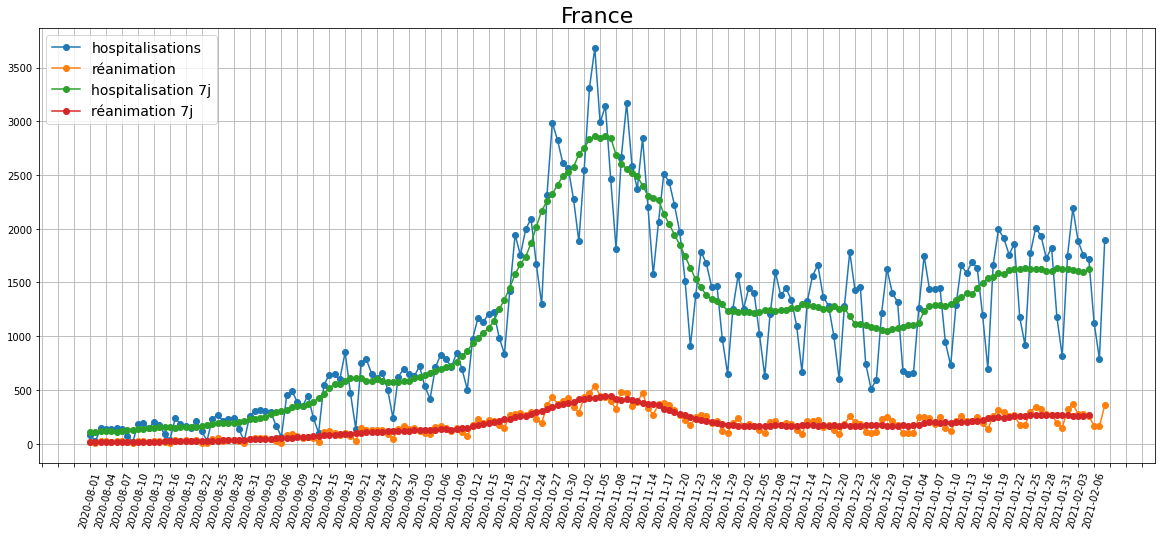


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05      1719.0      255.0      1622.0      265.0

hospitalisations pour 100k habitants 2.43
réanimations pour 100k habitants     0.40


In [35]:
display_hospi_dept(min_date="2020-08-01")
#sns.lineplot(data=prepare_hospi_age())
mpl.rcParams['figure.figsize'] = [20.0, 8.0]

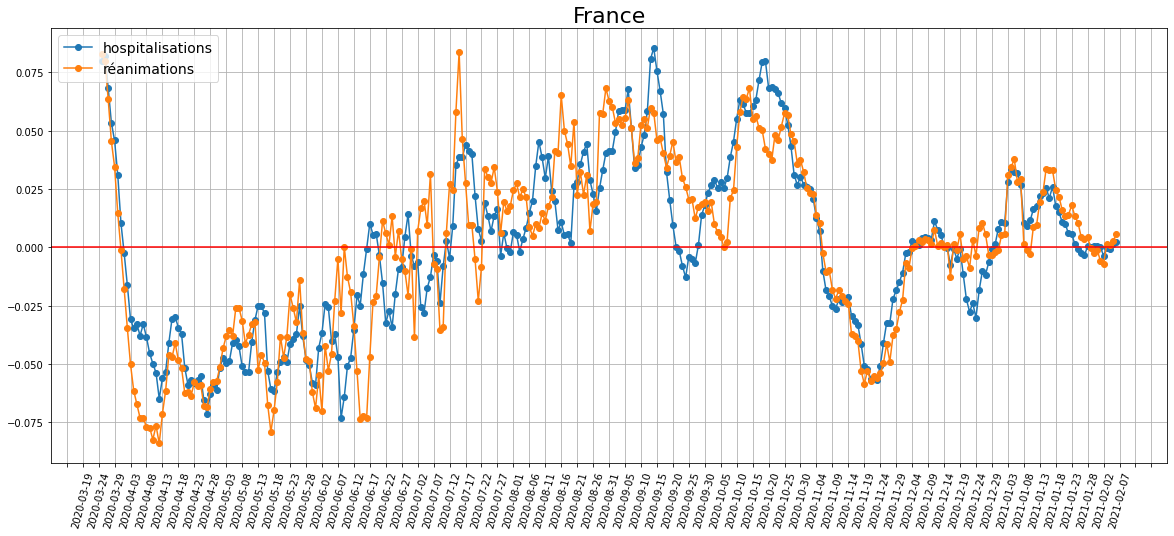

In [36]:
display_variation_hospi_dept()

## par département

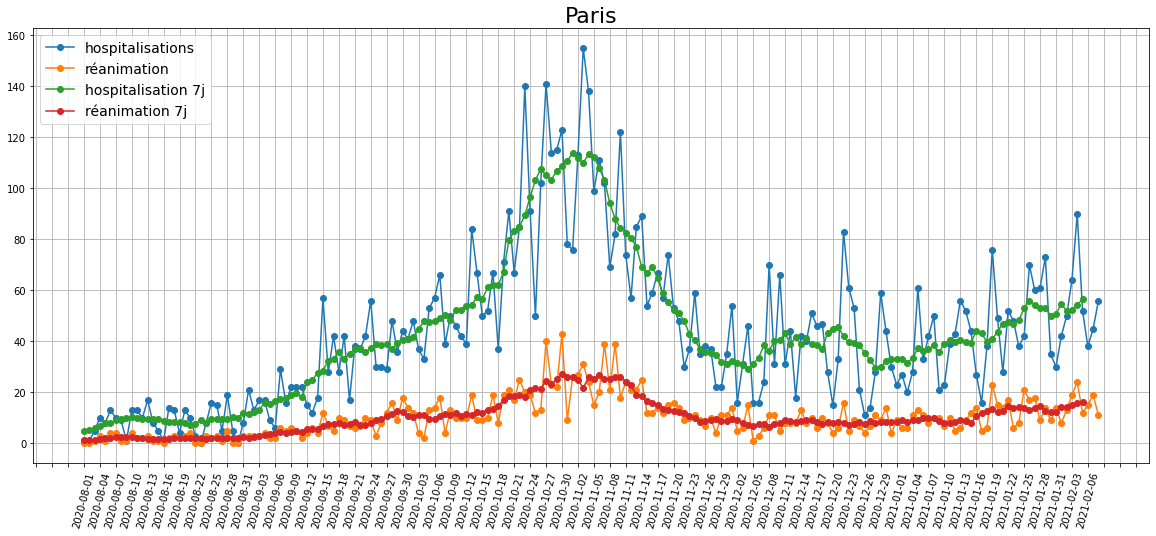


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05        52.0       12.0        56.0       16.0

hospitalisations pour 100k habitants 2.60
réanimations pour 100k habitants     0.74


In [37]:
display_hospi_dept("75", min_date="2020-08-01")

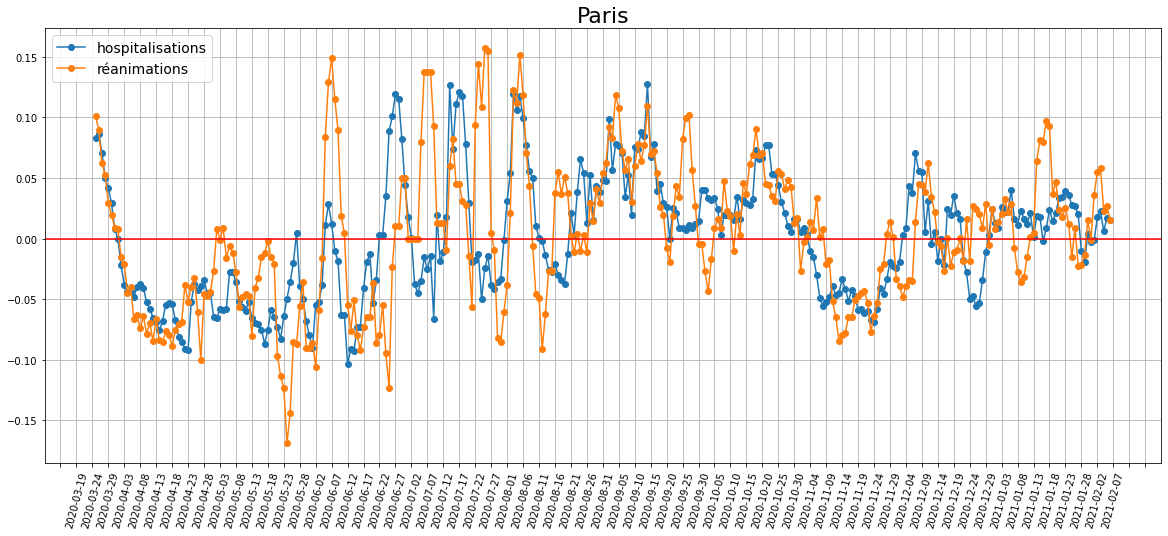

In [38]:
display_variation_hospi_dept("75")

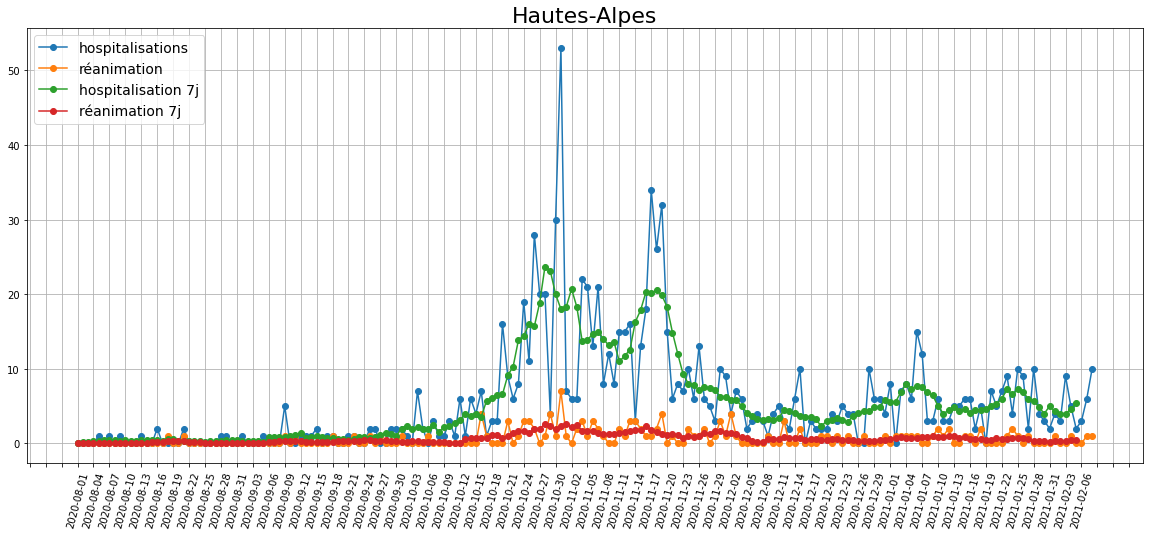


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05         2.0        0.0         5.0        0.0

hospitalisations pour 100k habitants 4.24
réanimations pour 100k habitants     0.40


In [39]:
display_hospi_dept("05", min_date="2020-08-01")

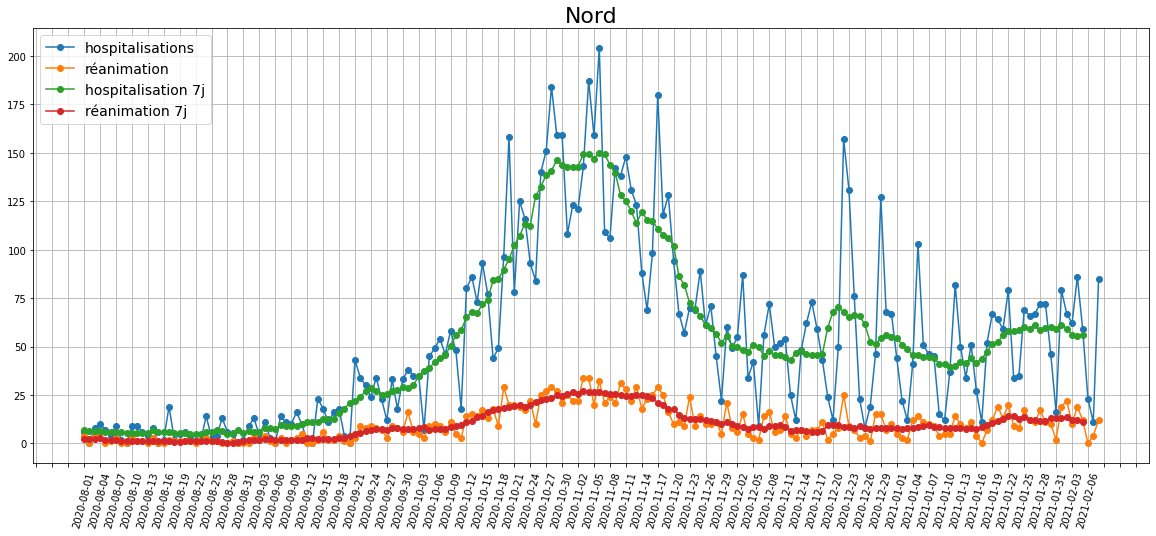


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05        59.0       12.0        56.0       11.0

hospitalisations pour 100k habitants 2.34
réanimations pour 100k habitants     0.51


In [40]:
display_hospi_dept("59", min_date="2020-08-01")

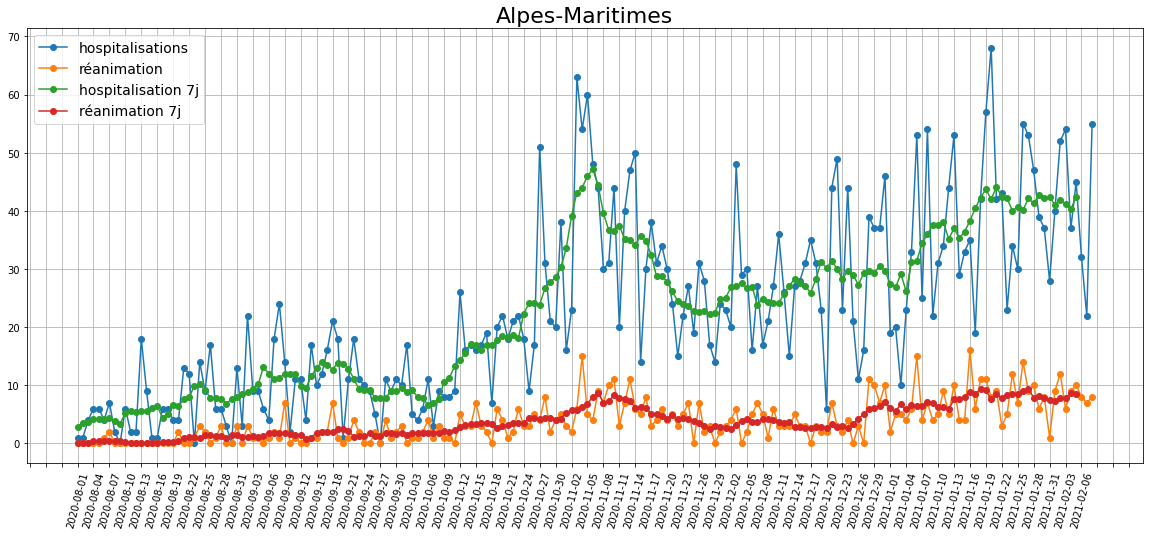


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05        45.0       10.0        42.0        9.0

hospitalisations pour 100k habitants 3.95
réanimations pour 100k habitants     0.87


In [41]:
dept = "06"
display_hospi_dept(dept, min_date="2020-08-01")

## par âge

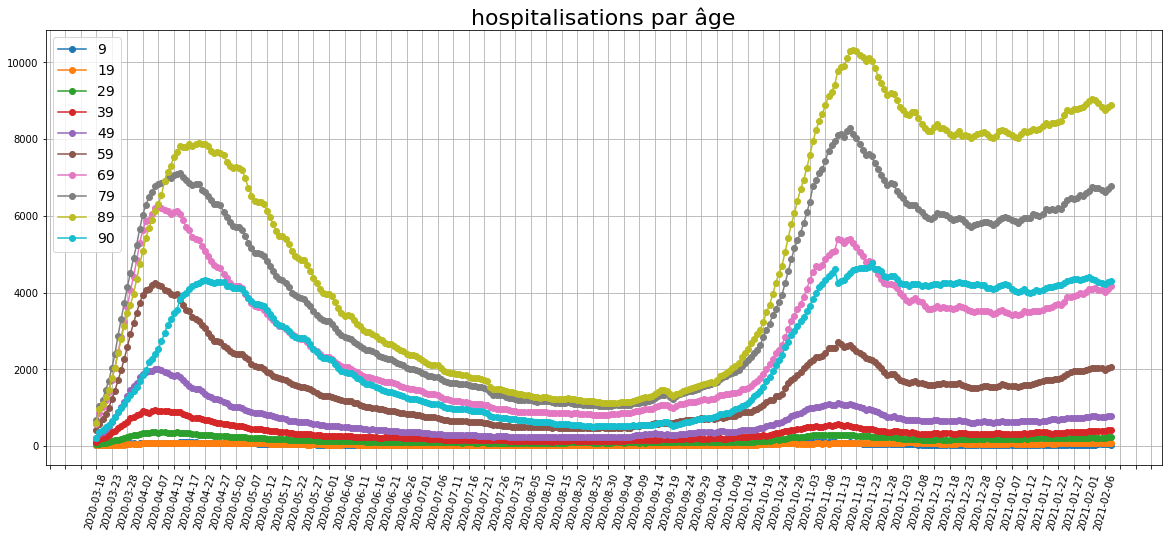

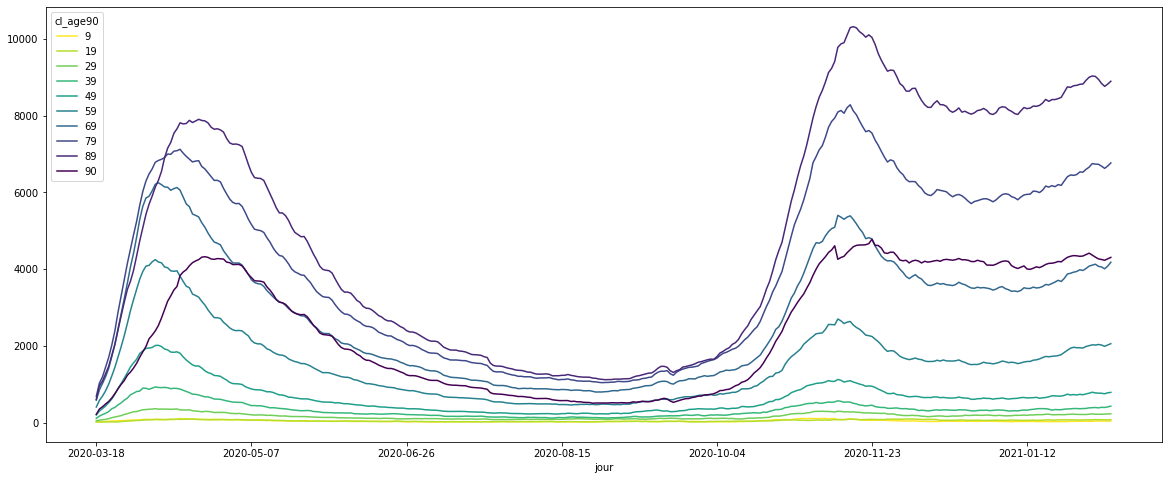

In [42]:
# hospi par âge
display_df(window(prepare_hospi_age(), min_date="2020-01-01"), title="hospitalisations par âge")
df = window(prepare_hospi_age(), min_date="2020-01-01")
colors = pl.cm.viridis(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

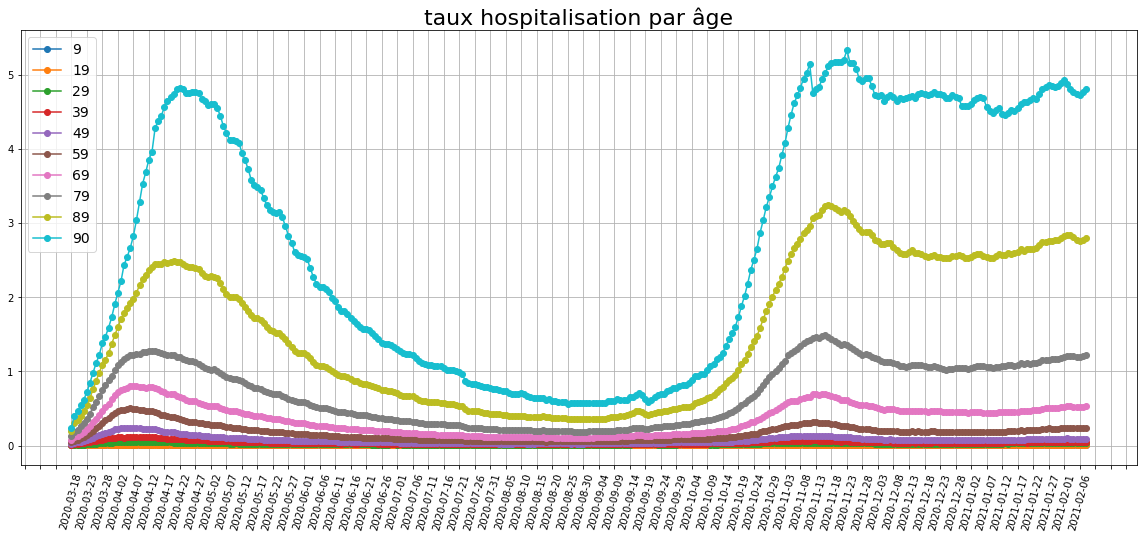

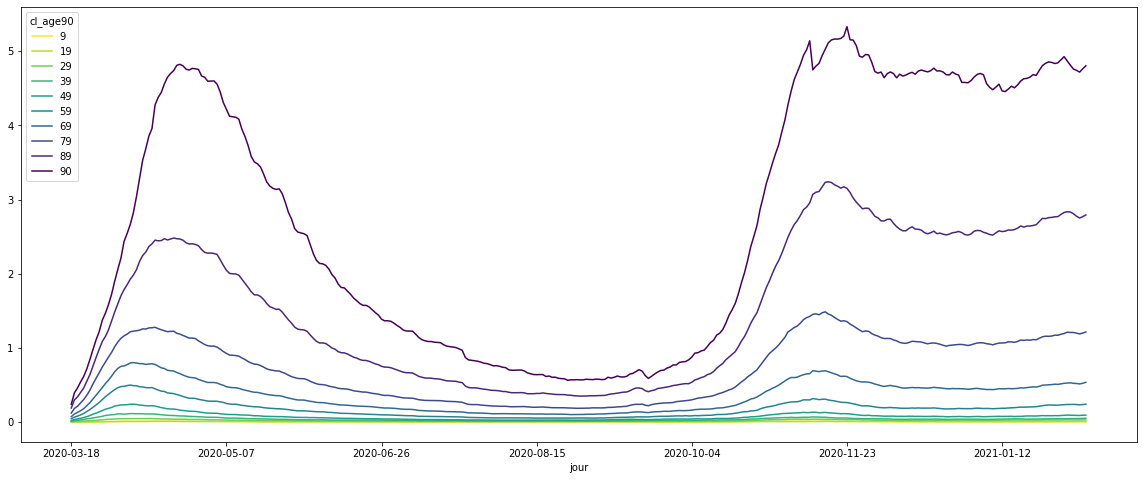

In [43]:
display_df(window(prepare_hospi_age(normalize=True), min_date="2020-01-01"), title="taux hospitalisation par âge")

# color maps perceptually uniform: viridis, plasma
# color maps diverging : PiYG, seismic
df = window(prepare_hospi_age(normalize=True), min_date="2020-01-01")
colors = pl.cm.viridis(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

In [44]:
# taux hospitalisaiton par âge
df.head()
fig = go.Figure(data=go.Heatmap(
    z=df.T,
    x=df.index,
    y=np.arange(9,100,10), #df.columns,
    colorscale = 'Viridis',
    )
)
fig.show()

# tests PCR

## France

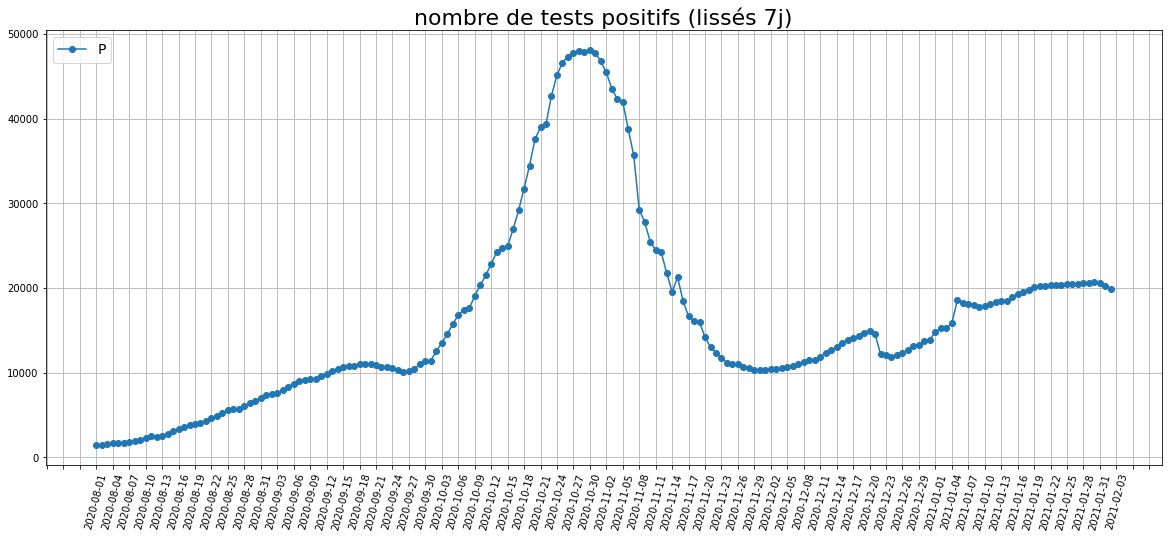

In [45]:
display_df(window(prepare_test(), min_date="2020-08-01")[["P"]], title="nombre de tests positifs (lissés 7j)")

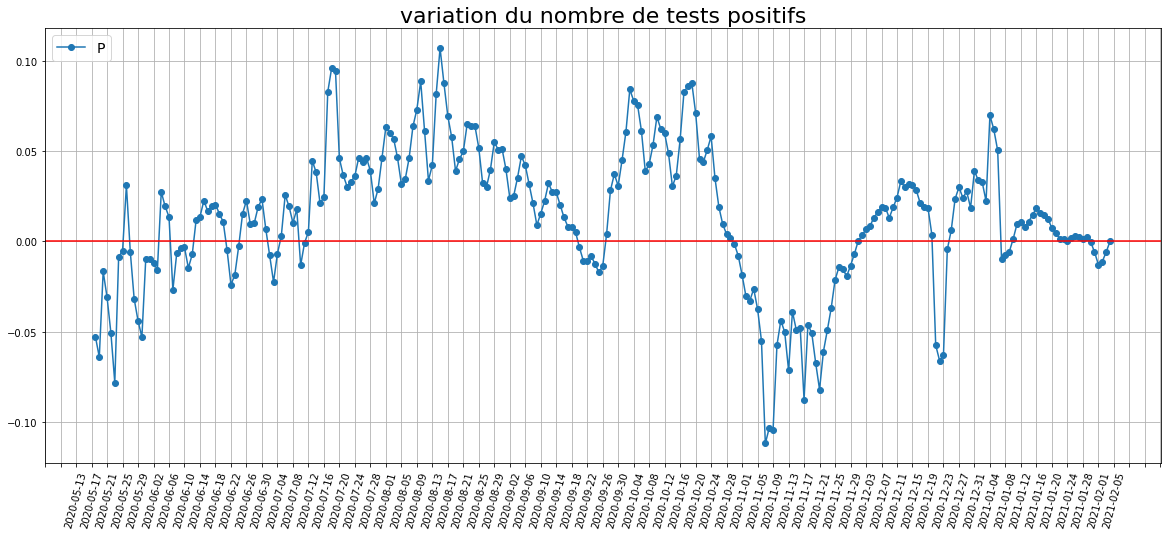

In [46]:
display_df(variation_test(lissage=3)[["P"]], title="variation du nombre de tests positifs", zero=True)

In [47]:
#@markdown version plotly
df = window(prepare_test(), min_date="2020-08-01")[["T", "P"]].reset_index()
df["R"] = df["P"] / df["T"]
#figure with multiple y axis

trace1 = go.Scatter(
    x=df['jour'],
    y=df['T'],
    name='tests',
    mode='lines+markers',
    yaxis='y1')
trace2 = go.Scatter(
    x=df['jour'],
    y=df['P'],
    name='positifs',
    mode='lines+markers',
    yaxis='y2')

trace3 = go.Scatter(
    x=df["jour"],
    y=df["R"],
    name="taux",
    mode="lines",
    yaxis='y3')


data = [trace1, trace2, trace3]
layout = go.Layout(
    title='tests, tests positifs, taux de positivité',
    xaxis=dict(domain=[0.08, 1]),
    yaxis=dict(title='tests', title_standoff = 0),
    yaxis2=dict(title='positifs', overlaying='y', side='left', position=0, anchor="free", title_standoff = 0),
    yaxis3=dict(title='taux', overlaying='y', side='right', title_standoff = 0)
)
fig = go.Figure(data=data, layout=layout)
fig.update_yaxes(rangemode="tozero")
fig.show()

## par âge

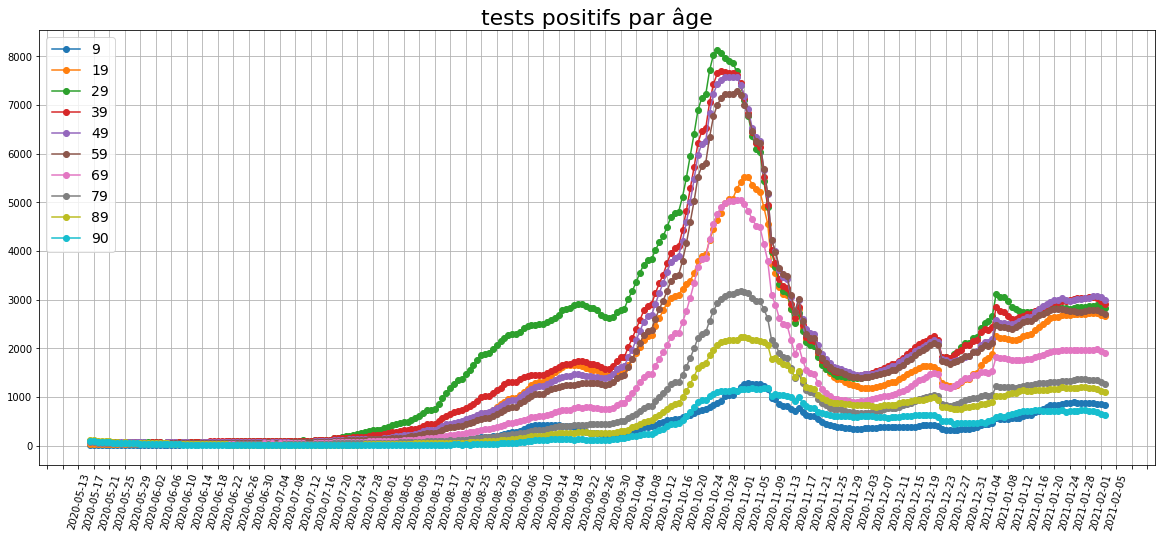

In [48]:
df = test_age[test_age.cl_age90 > 0]
df = df.pivot_table(index="jour", columns="cl_age90", values="P", aggfunc=sum).rolling(7, center=True).mean()
display_df(df, title="tests positifs par âge")

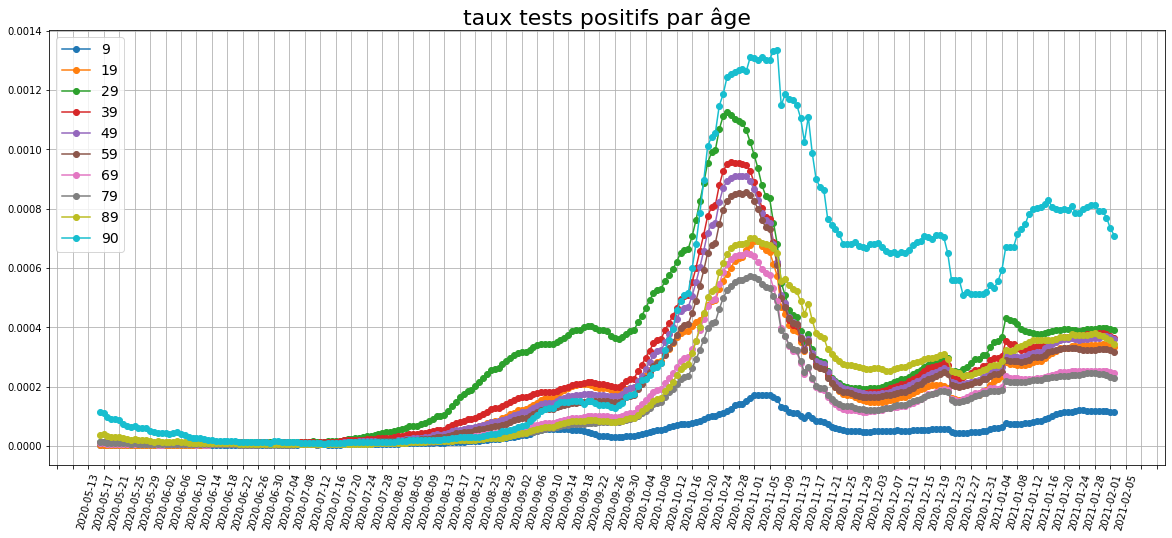

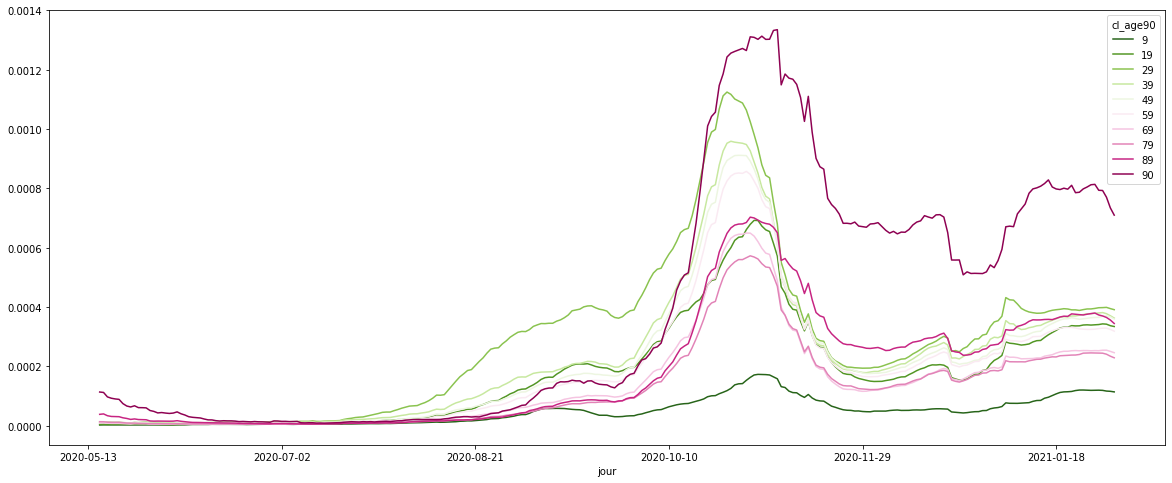

In [49]:
df = test_age[test_age.cl_age90 > 0]
df = df.pivot_table(index="jour", columns="cl_age90", values="P_norm", aggfunc=sum).rolling(7, center=True).mean()
display_df(df, title="taux tests positifs par âge")

colors = pl.cm.PiYG(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

In [50]:
df.head()
fig = go.Figure(data=go.Heatmap(
    z=df.T,
    x=df.index,
    y=np.arange(9,100,10), #df.columns,
    colorscale = 'Viridis',
    )
)
fig.update_layout(title="taux de tests positifs par âge")
fig.show()

# réanimations

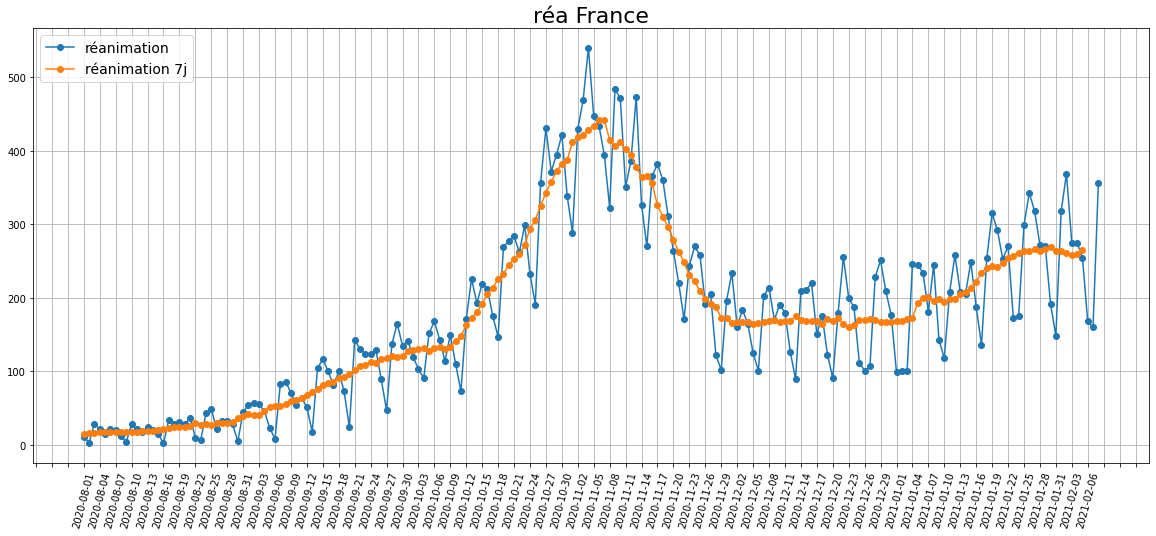


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05      1719.0      255.0      1622.0      265.0

hospitalisations pour 100k habitants 2.43
réanimations pour 100k habitants     0.40


In [51]:
display_rea_dept(min_date="2020-08-01")

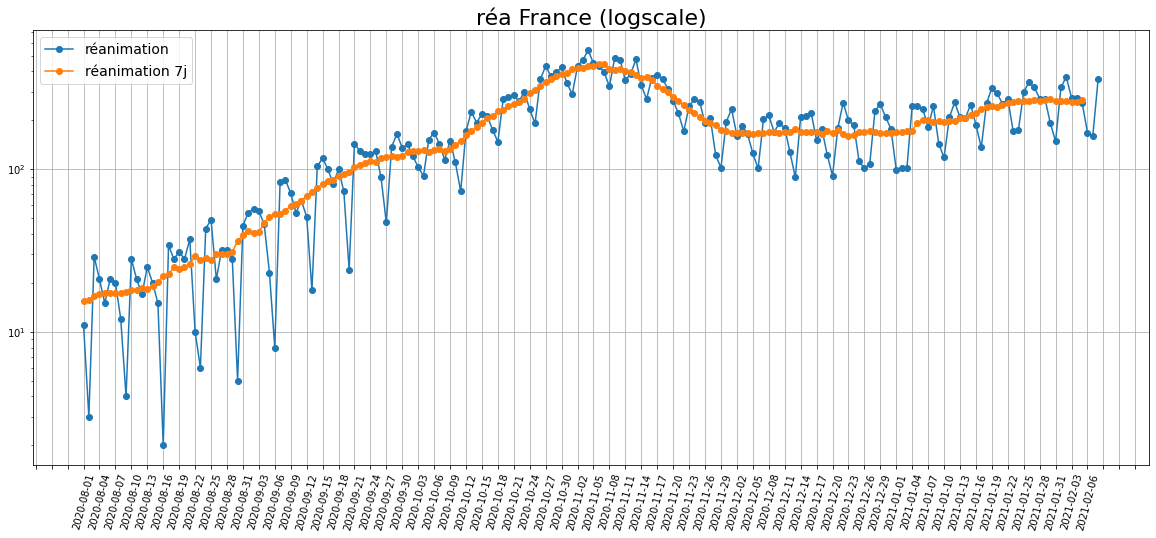


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05      1719.0      255.0      1622.0      265.0

hospitalisations pour 100k habitants 2.43
réanimations pour 100k habitants     0.40


In [52]:
display_rea_dept(min_date="2020-08-01", logscale=True)

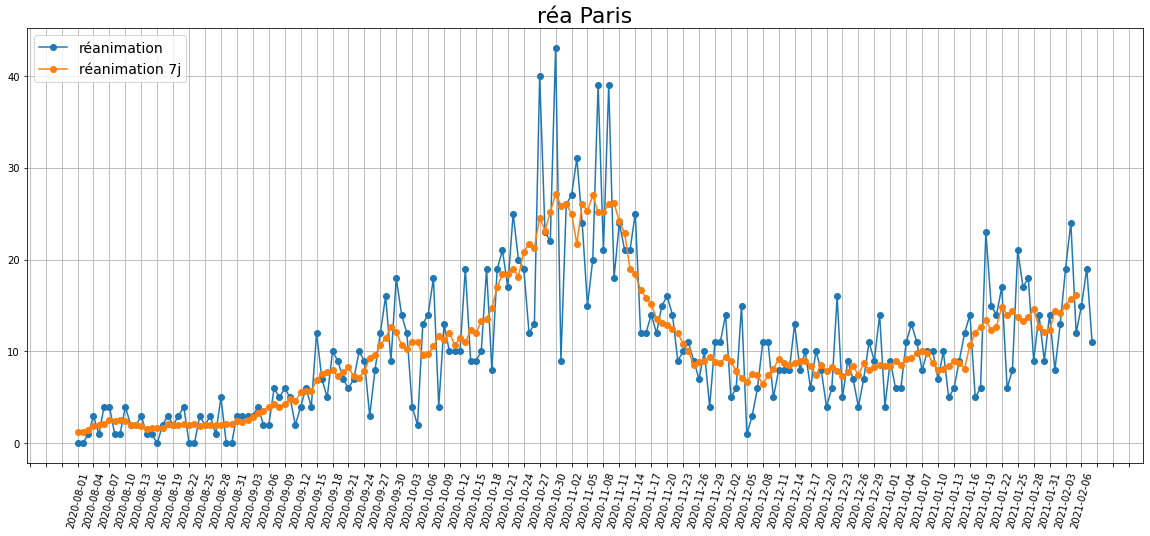


dernières données :
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2021-02-05        52.0       12.0        56.0       16.0

hospitalisations pour 100k habitants 2.60
réanimations pour 100k habitants     0.74


In [53]:
display_rea_dept(dept="75",min_date="2020-08-01")

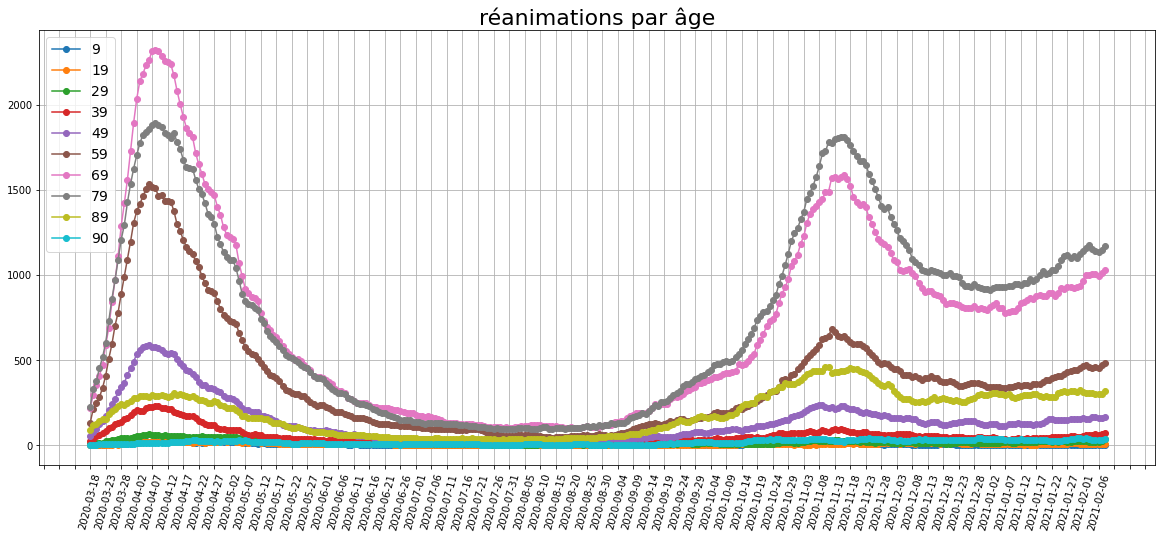

In [54]:
display_df(window(prepare_rea_age()),title="réanimations par âge")

In [55]:
df = prepare_rea_age(normalize=True)
df.head()
fig = go.Figure(data=go.Heatmap(
    z=df.T,
    x=df.index,
    y=np.arange(9,100,10), #df.columns
    colorscale = 'Viridis')
)
fig.show()

# SOS médecins et urgences

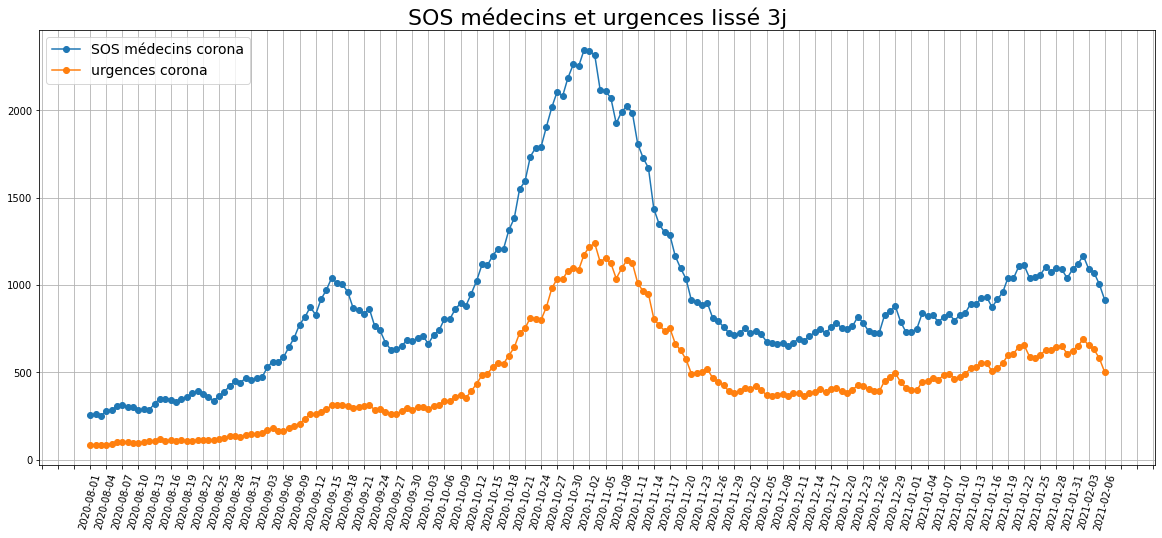

In [56]:
lissage = 3
display_df(window(
    sos_urgences.groupby(["date_de_passage"])[["nbre_pass_corona", "nbre_hospit_corona"]].sum().rolling(lissage, center=True).mean(),
    min_date="2020-08-01"),
    legend=["SOS médecins corona", "urgences corona"],
    title = f"SOS médecins et urgences lissé {lissage}j"
)

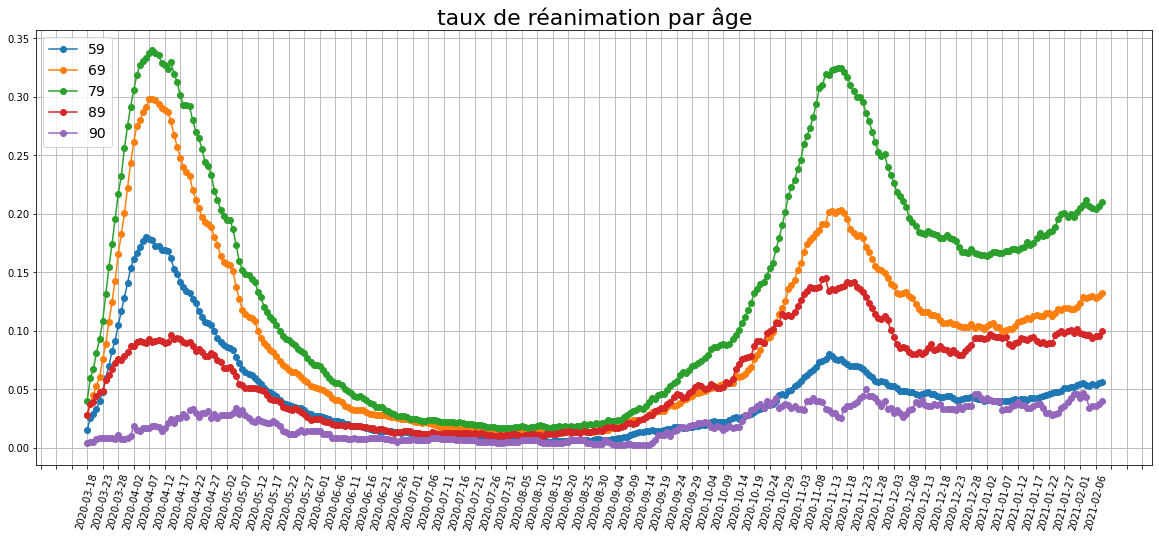

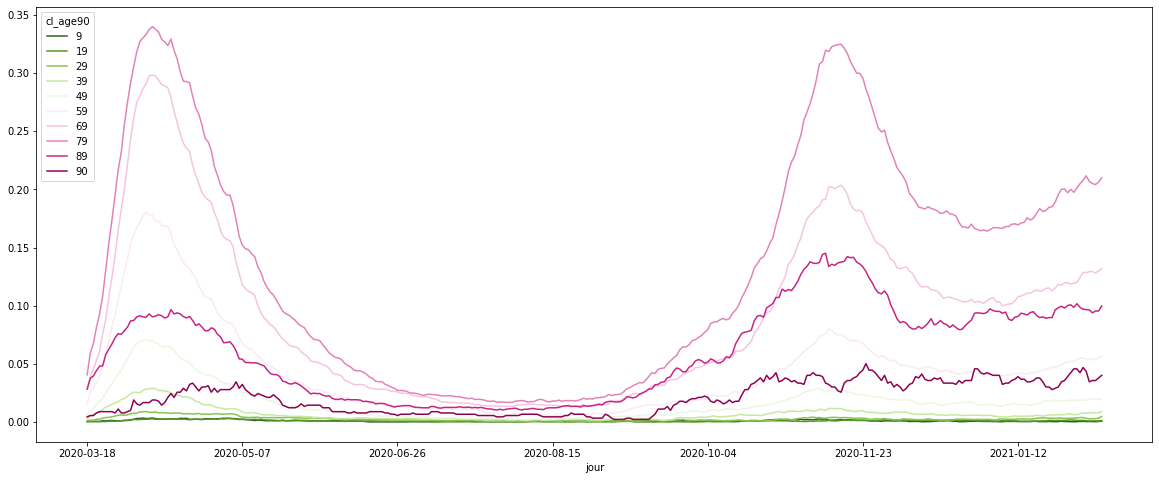

In [57]:
display_df(window(prepare_rea_age([59, 69, 79, 89, 90], normalize=True)),title="taux de réanimation par âge")

colors = pl.cm.PiYG(np.linspace(0,1,df.shape[1]))[::-1]
df.plot(color=colors)

# stock

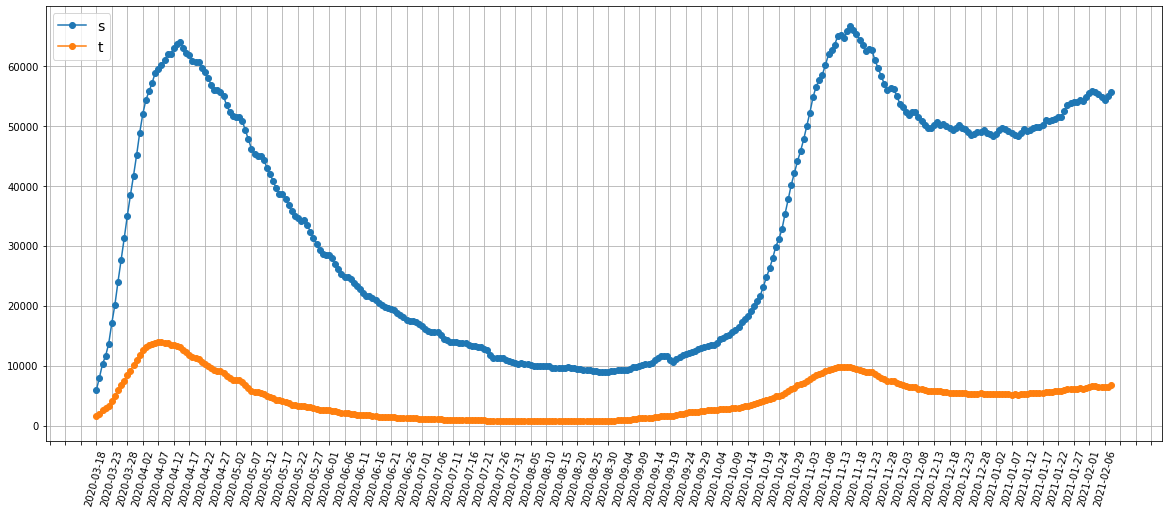

In [58]:
c = cumul.groupby(["jour"])[["hosp", "rea"]].sum()
display_df(c, "stock")

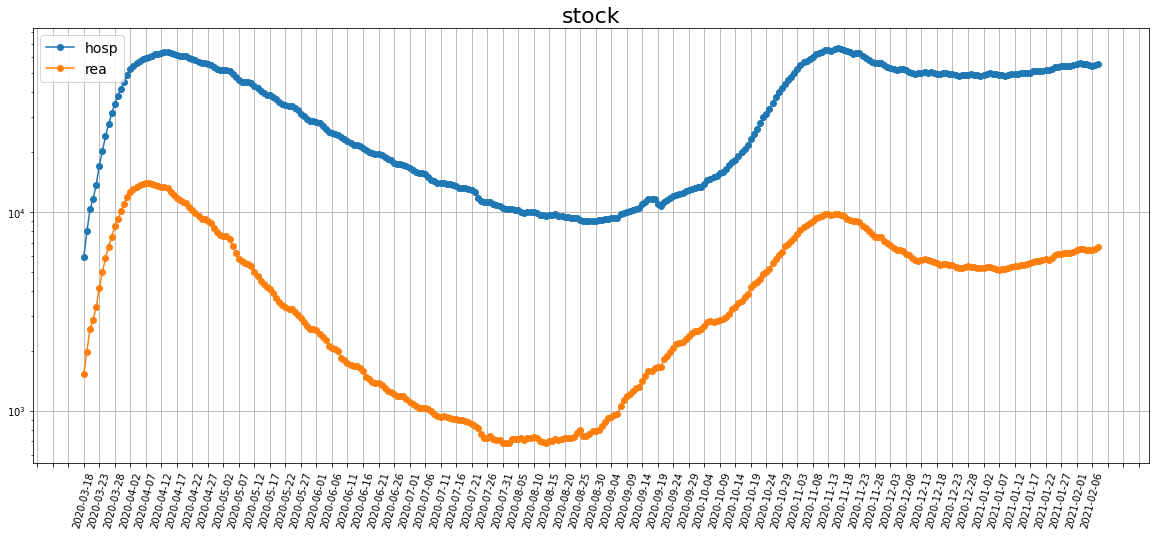

In [59]:
display_df(c, logscale=True, title="stock")

In [60]:
c = cumul.groupby(["jour"])[["hosp", "rea"]].sum().reset_index()
c = c.melt(id_vars= ["jour"], value_vars=["hosp", "rea"])
fig=px.line(c, x="jour", y="value",color="variable")
fig.show()